# TA Review 3
*1/30/2024*

## FINM 37400 - 2024

### UChicago Financial Mathematics

* Jordan Sacks
* jordansacks@uchicago.edu

### Agenda
- Forward Rates
- Forward Contracts
- Forward Rate Agreements

#### Libraries

In [2]:
import pandas as pd
import numpy as np
import datetime
import warnings
warnings.filterwarnings('ignore',category=FutureWarning)

from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from scipy.optimize import minimize

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (12,6)
plt.rcParams['font.size'] = 15
plt.rcParams['legend.fontsize'] = 13

from matplotlib.ticker import (MultipleLocator,
                               FormatStrFormatter,
                               AutoMinorLocator)
import sys
sys.path.insert(0, '../cmds')
from treasury_cmds import *

### Forwards

#### Definition
Forward Rates are the market expectation of the rate between two future time periods. Things to remember:
- the time period can be anything in the future. For example, the overnight rate in 1 year from now.
- A given term structure of spot rates implies a specific term structure of forward rates
- there is a forward rate market. It is over the counter (OTC) and thus participants can trade forwards over any time period. 
- market participants are usually large financial institutions with clear cash inflows and outflows. Imagine you are a real estate property owner with rental units all around the city and every month you receive rent from tenants. If you want to start construction of a new property in 1 year and lock in the rates that you could receive starting next month until construction begins, then you can buy a forward! 

#### Forward Rate Formula

$$ (1+f_{m,n})^{n-m} = \frac{(1+s_{n})^{n}}{(1+s_{m})^{m}}$$

#### Pricing via Replication

The forward rate is the interest rate for a loan between any two dates in the future, contracted today. Any forward rate can be "locked in" today by:
- BUY one unit of the n-year zero coupon bond at price
$ P_{n} = \frac{100}{(1 + s_{n})^{n}} $
- SELL $\frac{P_{n}}{P_{m}}$ units of the m-year zero bond at price
$ P_{m} = \frac{100}{(1 + s_{m})^{m}} $
- This ratio requires no net investment today because both the cash inflow and cash outflow amount to $P_{n}$

#### Data Example Through Replication
Lets assume the following using zero-coupon treasuries:

In [3]:
# Maturities
t1 = 1
t2 = 2

# Current Spot Rates
s1 = .06
s2 = .0808

# Implied Forward Rate
f12 = (1+s2)**t2 / (1+s1)**t1 - 1
print(f"Implied Forward Rate: {f12:.02%}")

Implied Forward Rate: 10.20%


Now lets assume this implied forward rate is exactly realized in one year from now (t=0) meaning the forward rate in 1 year becomes the spot rate for 1 year from then. Therefore, the value of the 2y zero-coupon bond

In [4]:
p2_t1 = 100 / (1+f12)**1
print(f"2Y Value at t=1: {p2_t1:.02f}")

2Y Value at t=1: 90.74


Today, the value of the 2Y is (based on current spot rates)

In [5]:
p2_t0 = 100 / (1+s2)**t2
print(f"2Y Value at t=0: {p2_t0:.02f}")

2Y Value at t=0: 85.61


To show that the implied forward perfectly replicates the information from the spot curves, lets calculate the return over the first year. We will see that the return is exactly equal to today's 1y spot rate

In [6]:
print(f"2Y Return from T=1 to T=2: {p2_t1 / p2_t0 - 1 : .02%}")

2Y Return from T=1 to T=2:  6.00%


Therefore, the implied forward rate is the break-even rate of the future 1y spot rate.

#### Holding a Forward
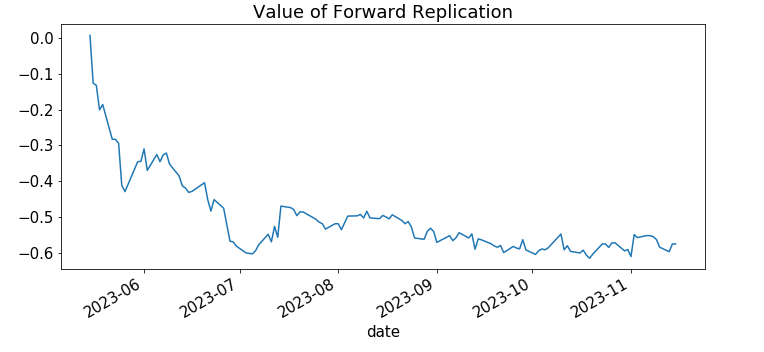

- At initialization, there is no value. But as time goes on, there is a value to if the rate you locked in at T=0 is more valuable / less valuable at T=t

#### Forwards and Spot Curves (Extracting Forward Curve from Spot Curve)

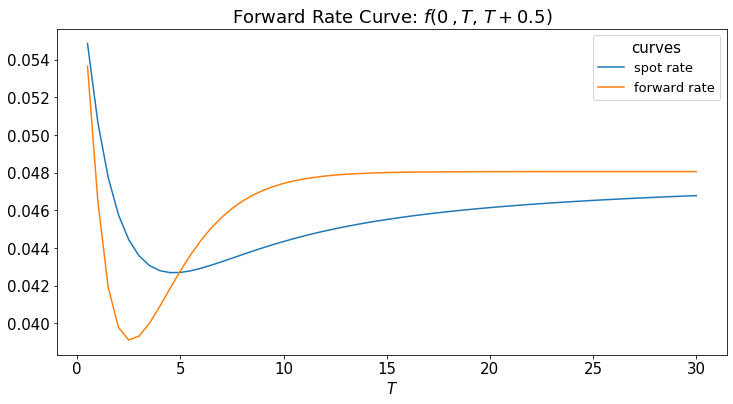

In [53]:
# Set parameters
qdate = '2023-11-30'
MODEL = nelson_siegel
DELTA = .5 # grid spacing of the maturities of the spot curve
MULT = 1 # Difference in maturities to calculate forward rates on times the Delta

# The MULT parameter allows for the forward rate interval, (T2-T1) to differ from the spot curve grid length. 
# Example: MULT = 2 and DELTA=0.5 would show forward rates calculated over 2*0.5 = 1.0 year intervals.

# Extract Spot Curve and then Calculate Forward
curve_set = dict()
curve_set[qdate] = extract_spot_curves(qdate, 
                                       model=MODEL, 
                                       delta_maturity=DELTA, 
                                       calc_forward=True, 
                                       delta_forward_multiple=MULT)

curves_set = pd.concat(curve_set,axis=1,names=['quote date','curves'])

# Initialize the first value of the forward at 0 (and the spot rate so the graph looks okay)
curves_set.iloc[0,:] = np.nan
curves = curves_set[qdate]

label_title = f'Forward Rate Curve: $f(0\, ,T,\,T+{DELTA})$'
curves[['spot rate','forward rate']].plot(title=label_title, xlabel='$T$')
plt.show()

In [54]:
curves_set.head()

quote date 2023-11-30                                            
curves      spot rate spot discount forward rate forward discount
maturity                                                         
0.01              NaN           NaN          NaN              NaN
0.50         0.054869      0.972938     0.053656         0.973529
1.00         0.050682      0.950581     0.046494         0.977021
1.50         0.047765      0.930860     0.041930         0.979253
2.00         0.045769      0.912527     0.039781         0.980306

**Notes** <br>
The forward curve is like the derivative of the spot curve. 
Whenever the forward curve is ABOVE the spot curve, the spot curve is RISING
Whenever the forward curve is BELOW the spot curve, the spot curve is FALLING

The forward curve is showing the rate you can lock in today from t -> t+0.5 <br>
Spot Rate is showing what rate you should earn from t=0 till T whereas forward curve is just a 6mo timeframe

#### Issues with Extracting Spot Curves from Forward Curves or Vice Versa

Given that the forward curve is a derivative of the spot curve, a small measurement error in the spot curve may lead to large measurement error in the forward curve.


Therefore, assuming we extract the forward from the spot curve, which tends to be less smooth?
- Forward curves tend to be less smooth than spot curves. In particular, this was relevant in that even if OLS extracts a reasonably behaved spot curve, it often implies an unreasonably behaved forward curve.

#### Example with Different Maturities (2023 Final Exam Question)

In [9]:
# Get Treasury Quotes
filepath = '../data/selected_treasury_quotes_2022-12-30.xlsx'
quotes = pd.read_excel(filepath, sheet_name='quotes').set_index('KYTREASNO')

# Build Cashflow Matrix
QUOTE_DATE = '2022-12-30'
t_date = pd.to_datetime(QUOTE_DATE)

CF = pd.DataFrame(data=0, index=quotes.index, columns=quotes['maturity date'])

for i in quotes.index:
    coupon_dates = get_coupon_dates(t_date,pd.to_datetime(quotes.loc[i,'maturity date']))

    if coupon_dates is not None:
        CF.loc[i,coupon_dates] = quotes.loc[i,'coupon rate']/2

    CF.loc[i,quotes.loc[i,'maturity date']] += 100

# 
CF = CF.resample('m',axis=1).sum()
CF.drop(columns=CF.columns[(CF==0).all()],inplace=True)
CF = CF.fillna(0).sort_index(axis=1)

# Bootstrap Spot Curve Discount Factors
COMPOUNDING = 2
spot = pd.DataFrame(np.linalg.solve(CF,quotes['price'].loc[CF.index]), index=CF.index, columns=['discount factor'])
spot.insert(0,'maturity',quotes['maturity'])
spot = spot.reset_index(drop=True).set_index('maturity')

# Get Spot Rates
spot['semiannual'] = discount_to_intrate(spot['discount factor'], spot.index, n_compound=COMPOUNDING)
spot['continuous'] = discount_to_intrate(spot['discount factor'], spot.index, n_compound=None)


In [10]:
CF.head()

maturity date,2023-06-30,2023-12-31,2024-06-30,2024-12-31,2025-06-30,2025-12-31,2026-06-30,2026-12-31,2027-06-30,2027-12-31
KYTREASNO,,,,,,,,,,
206990,100.6875,0.000,0.000,0.000,0.000,0.0,0.0,0.0,0.0,0.0
207047,1.1250,101.125,0.000,0.000,0.000,0.0,0.0,0.0,0.0,0.0
207374,0.8750,0.875,100.875,0.000,0.000,0.0,0.0,0.0,0.0,0.0
207166,1.1250,1.125,1.125,101.125,0.000,0.0,0.0,0.0,0.0,0.0
207224,1.3750,1.375,1.375,1.375,101.375,0.0,0.0,0.0,0.0,0.0


In [11]:
spot.head()

,discount factor,semiannual,continuous
maturity,,,
0.498289,0.977886,0.045384,0.044877
1.002053,0.954124,0.047419,0.046865
1.500342,0.933443,0.046437,0.045907
2.004107,0.916052,0.044233,0.043751
2.499658,0.899927,0.042630,0.042182


Based on the below spot rate curve (in blue), is the forward curve going to be below or above the spot curve?

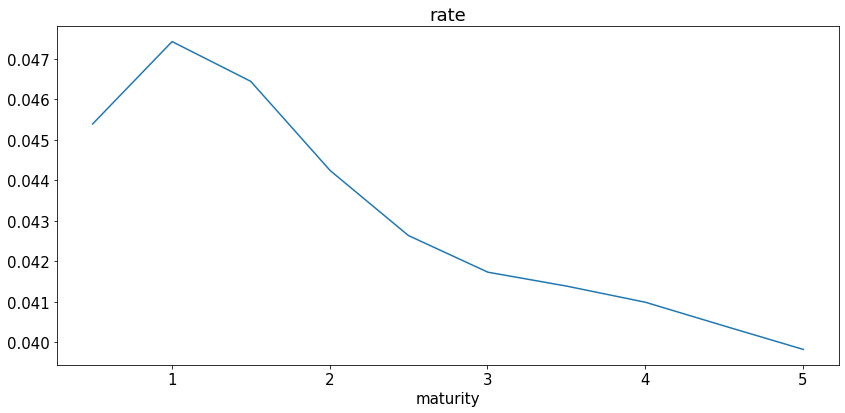

In [15]:
spot['semiannual'].plot(title='rate')
plt.tight_layout()
plt.show()

The spot curve is decreasing over the long rates.

Thus, we know the forward curve must be below the spot curve at the long end.

##### <span style="color:red">Forward Rate Question</span>
Calculate and report the continuously-compounded forward-rate curve, $f(t,T,T+1)$, for $0\le T \le 4$.

Also report the forward rate, $f(t,T_1,T_2)$, for $T_1=3, T_2=5$.

##### <span style="color:red">SOLUTION</span>

##### Interval
The question asks for forward interval equal to one year, (2 "periods" of six months each.)

The question in HW 4 asked about a forward interval of just half a year. So repeating that code would lead to a wrong answer.

The code below accounts for this with the variable `FORWARD_INTERVAL`, which is expressed in number of periods, not number of years. Thus, an interval of one year is a `FORWARD_INTERVAL=2`.

##### Compounding
The question asks for a **continuously** compounded forward. 

**Forward Discount Factors** <br> <br>
$\begin{align}
F(t,T_1,T_2) = \frac{Z(t,T_2)}{Z(t,T_1)}
\end{align}$


**Forward Discount Rate** 

$\begin{align}
f(t,T_1,T_2) \equiv & \quad -\frac{\ln\left\{F(t,T_1,T_2)\right\}}{T_2-T_1}\\[6pt]
\end{align}$


In [55]:
FORWARD_INTERVAL = 2

forward = pd.DataFrame(spot['discount factor']/spot['discount factor'].shift(FORWARD_INTERVAL),
                       index=spot.index, 
                       columns=['discount factor'])

forward['discount factor'].iloc[FORWARD_INTERVAL-1] = spot['discount factor'].iloc[FORWARD_INTERVAL-1]
forward['continuous'] = -np.log(forward['discount factor']) / forward.index.to_series().diff(FORWARD_INTERVAL).mean()
forward

,discount factor,continuous
maturity,,
0.498289,NaN,NaN
1.002053,0.954124,0.046961
1.500342,0.954551,0.046514
2.004107,0.960097,0.040721
2.499658,0.964095,0.036566
3.003422,0.964307,0.036346
3.498973,0.962825,0.037883
4.002738,0.962372,0.038354
4.498289,0.964062,0.036600


#### Two-year forward rate

$F(t,T_1,T_2)$ and $f(t,T_1,T_2)$ for $T_1=3, T_2=5$.

In [17]:
FWD_INTERVAL = 4
F_2 = spot['discount factor'].iloc[-1] / spot['discount factor'].iloc[-1-FWD_INTERVAL]
f_2 = -np.log(F_2) / (FWD_INTERVAL/2)

fwd_2 = pd.DataFrame(np.array([[F_2,f_2]]),index=['T_1=3, T_2=5'],columns=['F','f'])
fwd_2.style.format({'F':'{:.6f}','f':'{:.4%}'})

,F,f
"T_1=3, T_2=5",0.929424,3.6595%


### Forward Contracts
#### Definition
A forward contract is an agreement to buy a bond with maturity $T$
- at a specific time in the future, $T_0$
- at a specific price, $P_{\text{Fwd}}(t,T_0,T)$ <br>

Essentially, I am going to contract today to buy a bond in the future

#### Initalization
The forward price is set such that there is no price to initiate the forward contract. 
* That is, the value to the contract is 0 at initialization

#### Pricing

Pricing forward contracts on treasuries is easy:
* just use the discount $F(t,T_0,T)$ instead of $Z(t,T)$!
* This means that we are essentially discounting the future cash flows but using forward discount factors because instead of discounting to T=0, we want to discount to T=1 for when we would be contracted to own the bond

##### Zero coupon bond

- Consider a zero-coupon bond maturing at $T$, with face value of 100.
- Consider a forward contract, initialized at $t$ for purchase at $T_0$.

$\begin{align}
P_{\text{Fwd}}(t,T_0,T) = 100F(t,T_0,T)
\end{align}$

##### Coupon bond
Consider now that there are coupons at $T_i$, with final principal repaid at $T_n=T$.

$\begin{align}
P_{\text{Fwd}}(t,T_0,T) = 100\frac{c}{2}\sum_{i=1}^nF(t,T_0,T_i) + 100F(t,T_0,T)
\end{align}$

#### Example:
- A 10Y bond is trading a specific rate. You want to lock in the rate that it trades at starting next year when it has 9years left of maturity

#### Uses
- Hedging interest rate exposure
- Speculation on term structure

#### Notes
- Pricing this uses the same information derived from the spot rate curve / forward rate curve or other rate information available today. It is all synthetized based on current treasury market data

### Forward Rate Agreements (FRAs)

#### Definition
A forward rate agreement (FRA) is a cash-settled over-the-counter (OTC) contract between two counterparties, where the buyer is borrowing (and the seller is lending) a notional sum at a fixed interest rate (the FRA rate) and for a specified period starting at an agreed date in the future.
- the party entering the FRA does not deposit the capital. Instead, the party entering the FRA pays the spot rate, $r(T_1,T_2)$, on the notional.

The purpose of FRA is to lock in borrowing or a lending rate for some time in the future. Typically, it involves two parties exchanging a fixed interest rate for a floating rate.

- The borrower: The long pays a fixed rate and receives floating rates. If SOFR rises, the long will gain.
- The lender: The short pays a floating rate and receives a fixed rate. If SOFR falls, the short will gain. <br>

The FRA buyer enters into the contract to protect itself from a **future** increase in interest rates; the seller of the FRA wants to protect itself from a future decline in interest rates.



#### Uses
- A FRA can be used to hedge future interest rate or exchange rate exposure.

- The buyer hedges against the risk of rising interest rate whereas the seller hedges against the risk of falling interest rates. In other words, the buyer locks in the interest rate to protect against the increase of interest rates while the seller protects against the possible decrease of interest rates.

- A speculator can also use FRAs to make bets on future directional changes in interest rates.

- Market participants can also take advantage of price differences between an FRA and other interest rate instruments.


#### Formulas

##### Cashflow Amount
The net receipt for the investor is, using a compounding frequency, $n$,

$\begin{align}
& \quad N \Delta\left[f_n(0,T_1,T_2)-r_n(T_1,T_2)\right]\\[6pt]
\Delta \equiv & \quad T_2-T_1\\[6pt]
N \equiv & \quad \text{Notional Investment}
\end{align}$

##### Ending Value
The **value** of the FRA is the cashflow above, discounted by the appropriate spot discount factor, $Z(t,T)$.

The result is the **following equation**:

$\begin{align}
V_{\text{FRA}}(t;0,T_1,T_2) = N\Delta\left[f_n(0,T_1,T_2)-f_n(t,T_1,T_2)\right]Z(t,T_2)
\end{align}$

#### Data Example of Valuing FRA

Note that the price is a function of 4 dates:
- $t=0$: initialization date of the forward
- $T_1$: the date of the spot rate fix
- $T_2$: the date of settlement
- $t$: the date of the pricing


#### Boundaries
Note that 
- For $t=0$, the value is 0. That is, an FRA is set up such that no payment is required at initialization.
- One could view this as the determining feature of the forward price.
- For $t=T_2$, we get the value equals the net cashflow at maturity given above,

$\begin{align}
V_{\text{FRA}}(0;0,T_1,T_2) =& \quad  N\Delta\left[f_n(0,T_1,T_2)-f_n(0,T_1,T_2)\right]Z(0,T_2) = 0\\ 
V_{\text{FRA}}(T_2;0,T_1,T_2) =& \quad N \Delta\left[f_n(0,T_1,T_2) - r_n(T_1,T_2)\right]
\end{align}$

In [40]:
# Set Parameters
t0 = '2023-05-15'
t = '2023-07-26'
T1 = '2023-11-15'
T2 = '2024-05-15'
MODEL = nelson_siegel
DELTA = .5 # Difference between t0 and T1
MULT = 1 

In [41]:
# Extract spot curve and calculate forward curve
curve_interim = extract_spot_curves(t, model=MODEL, delta_maturity=.25, calc_forward=True, delta_forward_multiple=2)
curve_interim.head()


2023-07-26,spot rate,spot discount,forward rate,forward discount
maturity,,,,
0.01,0.062153,0.999379,0.001243,0.999379
0.25,0.059666,0.985194,0.029833,0.985194
0.50,0.057343,0.971736,0.056100,0.972340
0.75,0.055264,0.959399,0.053063,0.973818
1.00,0.053405,0.947996,0.049466,0.975570


In [42]:
# Calculate FRA value at T=t
'''
-Calculate difference in forward rates multiplied by spot discount factor
-Difference of forward rates is T2 - T1
-Spot Discount Factor is assuming Z(t, T2)
'''

fra = DELTA * MULT * (curve_set[QUOTE_DATE].loc[.5,'forward rate'] - curve_interim.loc[.25,'forward rate']) * curve_interim.loc[.75,'spot discount']
fra

0.00919206834274238

In [45]:
# Calculate hypothetical FRA value at T=T2
'''
-Calculate difference in forward rate vs spot rate at T2
-No need to discount because we are at T2
'''
fra_hypothetical = DELTA * MULT * (curve_set[QUOTE_DATE].loc[.5,'forward rate'] - curve_interim.loc[.5,'spot rate'])
fra_hypothetical

-0.004173756108705254

In [46]:
# Display results
fra_tab = pd.DataFrame({'$f(0,T_1,T_2)$': curve_set[QUOTE_DATE].loc[.5,'forward rate'], '$f(t,T_1,T_2)$': curve_interim.loc[.25,'forward rate'], '$r(T_1,T_2)$':np.nan, '$Z(t,T_2)$': curve_interim.loc[.75,'spot discount'], '$P(t;0,T_1,T_2)$': fra},index=[t]).T
fra_tab_hypo = pd.DataFrame({'$f(0,T_1,T_2)$': curve_set[QUOTE_DATE].loc[.5,'forward rate'], '$f(t,T_1,T_2)$':np.nan, '$r(T_1,T_2)$': curve_interim.loc[.5,'spot rate'], '$Z(t,T_2)$': 1, '$V(t;0,T_1,T_2)$': fra_hypothetical},index=[f'Hypothetical: {T1}']).T

index_special = fra_tab.index[-2:]
index_highlight = fra_tab.index[-1]

pd.concat([fra_tab,fra_tab_hypo],axis=1)

,2023-07-26,Hypothetical: 2023-11-15
"$f(0,T_1,T_2)$",0.048995,0.048995
"$f(t,T_1,T_2)$",0.029833,NaN
"$r(T_1,T_2)$",NaN,0.057343
"$Z(t,T_2)$",0.959399,1.000000
"$P(t;0,T_1,T_2)$",0.009192,NaN
"$V(t;0,T_1,T_2)$",NaN,-0.004174


***